In [ ]:
!pip install neurokit2
!pip install pandas==2.3.3
!pip install wfdb

import pandas as pd
import numpy as np
import wfdb
import ast
from google.colab import drive

# Mount Google Drive
import zipfile
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 134.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Define the path to the zip file and the extraction directory
zip_file_path = 'ptb-xl-100hz.zip'
extraction_dir = 'ptb-xl-100hz'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_dir)

    print(f"Files extracted to {extraction_dir}")




Files extracted to ptb-xl-100hz


# Data Loading and Preprocessing

In [ ]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

# Update the path to your Google Drive
path = 'ptb-xl-100hz/ptb-xl-100hz/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) # takes all scp statements in the file
agg_df = agg_df[agg_df.diagnostic == 1] # filters them to only include diagnostic statements

def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
valid_fold = 9


# Train
X_train = X[np.where(Y.strat_fold <valid_fold)]
y_train = Y[(Y.strat_fold <valid_fold)].diagnostic_superclass

# Validation
X_valid = X[np.where(Y.strat_fold == valid_fold)]
y_valid = Y[(Y.strat_fold == valid_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass





In [ ]:
import numpy
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
import neurokit2 as nk



def create_dataset(data, labels, clean, split):

  """
  Data formatted as [R, S, L]
  R: record
  S: number of samples or sample index / features
  L: lead

  Each record has 1000 samples (as its 100hz recording over 10 seconds so 100*10)
  Each sample in the record has data for each lead.

  """

  inv_labels_map = {
      0: 'NORM',
      1: 'HYP',
      2: 'MI',
      3: 'CD',
      4: 'STTC',
  }

  labels_map = {v:k for k,v in inv_labels_map.items()}

  final_labels = []
  final_data = []
  removed = []



  for i, item in enumerate(labels.values):
    if item:

      twelve_lead1 = []
      twelve_lead2 = []



      for lead in range(12):



        temp_data = data[i,:,lead]



        if clean:

          temp_data = nk.ecg_clean(data[i,:,lead],100)


        if split:
          twelve_lead1.append(temp_data[:500])
          twelve_lead2.append(temp_data[500:])

        else:
          twelve_lead1.append(temp_data)



      final_labels.append(labels_map[item[0]])
      final_data.append(twelve_lead1)

      if split:
        final_labels.append(labels_map[item[0]])
        final_data.append(twelve_lead2)



    else:
      removed.append(i)

  return removed, TensorDataset(torch.Tensor(np.array(final_data)), torch.LongTensor(final_labels))


leads = ['I', 'II', 'III', 'aVR' , 'aVL','aVF','V1','V2','V3','V4','V5','V6']




# for multilabel maybe do embeddings
#weight classes with the crossentropyloss torch func

In [ ]:


lead_num = 1 # defunct for multi-lead

clean = True
split = True


train_removed, train_dataset = create_dataset(X_train, y_train, clean, split)


valid_removed, valid_dataset = create_dataset(X_valid, y_valid, clean, split)

test_removed, test_dataset = create_dataset(X_test, y_test, clean, split)

# Datasets in format [R,L,S]
"""
torch.manual_seed(1)

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

# This splits data into [B, Rb, L, S] for X data and [B, Rb, L, T] for y data where B = number of batches, Rb = records in batch 50 until final batch  and T = label/truth
# for the case of train_dl X = [342, Rb, 1000] Rb is 50 for all but the last entry where it is 34"""

counts_train = torch.unique(train_dataset.tensors[1], return_counts=True)[1]
total_train = sum(counts_train)

print(total_train)

weighting = torch.Tensor([i/total_train for i in counts_train])




tensor(34168)


# Model Code

In [ ]:
import torch.nn as nn
import math

class PatchEmbed1D(nn.Module):

  def __init__(self, patch_size, embed_dim, num_leads=12):
    super().__init__()
    self.num_leads = num_leads
    self.patch_size = patch_size
    self.embed_dim = embed_dim

    self.proj = nn.Conv1d(num_leads, num_leads*embed_dim, patch_size, groups=num_leads, stride=patch_size) # outputs [B, L*D, N] Where D = embed dimension and N is number of patches

  def forward(self,x):
    x = self.proj(x) # B L*D, N

    B, _, N = x.size()
    x = x.view(B, self.num_leads, self.embed_dim, N).transpose(2,3) # B, L, N, D
    return x

class PositionalEncoding(nn.Module):
  def __init__(self, embed_dim, seq_len):
    super().__init__()
    position_encoding = torch.zeros(seq_len, embed_dim) # N, D
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # N 1
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
    position_encoding[:, 0::2] = torch.sin(position * div_term) # every odd term
    position_encoding[:, 1::2] = torch.cos(position * div_term) # every even term
    position_encoding = position_encoding.unsqueeze(0).unsqueeze(0)
    self.register_buffer('position_encoding', position_encoding) # puts the pos encoding on gpu 1 N D

  def forward(self, x):
      return x + self.position_encoding

class LeadEncoding(nn.Module):
  def __init__(self, num_leads, embed_dim, seq_len):
    super().__init__()

    lead_encoding = torch.zeros(num_leads, embed_dim) # N, D
    lead = torch.arange(0, num_leads, dtype=torch.float).unsqueeze(1) # N 1
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
    lead_encoding[:, 0::2] = torch.sin(lead * div_term) # every odd term
    lead_encoding[:, 1::2] = torch.cos(lead * div_term) # every even term
    lead_encoding = lead_encoding.unsqueeze(0).unsqueeze(2)
    self.register_buffer('lead_encoding', lead_encoding) # puts the pos encoding on gpu 1 N D

  def forward(self, x):
      return x + self.lead_encoding


class FeedForward(nn.Module):
  def __init__(self, embed_dim, mlp_hidden, dropout):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, mlp_hidden),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden, embed_dim),
        nn.GELU(),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return x + self.mlp(x)

class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_hidden, dropout, device):
    super().__init__()

    self.num_heads = num_heads
    self.device = device

    self.s_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
    self.s_mlp = FeedForward(embed_dim, mlp_hidden, dropout)

    self.t_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
    self.t_mlp = FeedForward(embed_dim, mlp_hidden, dropout)



    self.t_norm = nn.LayerNorm(embed_dim)
    self.s_norm = nn.LayerNorm(embed_dim)

    self.fuse = nn.Linear(2*embed_dim, embed_dim)

  def forward(self, x):
    # x: (B, L, N, D)
    B, L, N, D = x.shape


    # Masking
    # Temporal Branch with masking, across tokens per lead
    t_mask = (torch.rand((N,N), device=self.device) > 0.7)
    tc_mask = torch.triu(torch.full((N, N), float('-inf'), device=self.device), diagonal=1)

    t = self.t_norm(x.view(B*L, N, D))
    t, _ = self.t_attention(t,t,t, attn_mask=t_mask, is_causal=False)
    t = self.t_mlp(t)
    t = t.view(B, L, N, D)

    # Spatial Branch with masking, across leads per token/patch

    s_mask = (torch.rand((L,L), device=self.device) > 0.9) # prev 0.7
    sc_mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)

    s = self.s_norm(x.transpose(1,2).contiguous().view(B*N, L, D))
    s, _ = self.s_attention(s,s,s, attn_mask=s_mask, is_causal=False)
    s = self.s_mlp(s)
    s = s.view(B, N, L, D).transpose(1,2).contiguous()

    x = x + self.fuse(torch.cat([t, s], dim = -1)) #fused


    # No Masking
    # Temporal Branch, across tokens per lead
    t = self.t_norm(x.view(B*L, N, D))
    t, _ = self.t_attention(t,t,t)
    t = self.t_mlp(t)
    t = t.view(B, L, N, D)

    # Spatial Branch, across leads per token/patch

    s = self.s_norm(x.transpose(1,2).contiguous().view(B*N, L, D))
    s, _ = self.s_attention(s,s,s)
    s = self.s_mlp(s)
    s = s.view(B, N, L, D).transpose(1,2).contiguous()


    fused = torch.cat([t, s], dim = -1)

    # [B, C, N, D]

    """

    Perhaps for better interpretability:

    gate = self.gate_proj(x.view(B*L*N, D)).view(B, L, N, D) # in (0,1)
    out = gate * t + (1.0 - gate) * s return out

    """

    fused = self.fuse(fused)

    x = x + fused

    return x

class TransformerECG(nn.Module):
  def __init__(self, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, device, seq_len):
    super().__init__()

    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.num_leads = num_leads



    self.patch = PatchEmbed1D(self.patch_size, self.embed_dim, self.num_leads)

    self.blocks = nn.ModuleList([
        TransformerBlock(embed_dim, num_heads, mlp_dim, dropout, device) for _ in range(depth)
    ])

    L_IN = seq_len # number of records per lead. Constant
    self.N = (L_IN - patch_size) // patch_size + 1 # derived from equation from pytorch docs given padding = 0, dialation =1 and stride = 1
    self.pos_encoding = PositionalEncoding(self.embed_dim, self.N)
    self.lead_encoding = LeadEncoding(self.num_leads, self.embed_dim, self.N)

    self.lin_norm = nn.LayerNorm(2*embed_dim)


    self.mlp_head = nn.Linear(2*embed_dim, 5)




  def forward(self, x):

    #encodings and embeddings
    x = self.patch(x)
    x = self.pos_encoding(x)
    x = self.lead_encoding(x)

    B , L , N , D = x.size()


    for block in self.blocks:
      x = block(x)


    #print(x.shape) Classify per lead

    B, L, N, D = x.shape
    tokens = x.reshape(B, L * N, D)
    mean_pool = tokens.mean(dim=1) # (B, D)
    max_pool, _ = tokens.max(dim=1) # (B, D)
    pooled = torch.cat([mean_pool, max_pool], dim=1) # (B, 2*D)
    logits = self.mlp_head(self.lin_norm(pooled)) # (B, num_classes) return logits

    return logits









In [ ]:
import torch
N=5
torch.triu(torch.full((N, N), float('-inf')), diagonal=1)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

# Model Training Function

In [ ]:


def train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=None, lam=0.01, num_epochs=50):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs

    best_loss = 1000

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:

            x_batch = x_batch.cuda(non_blocking=True)
            y_batch = y_batch.cuda(non_blocking=True)

            pred = model(x_batch)

            #print(pred)
            #print(pred.shape)

            loss = loss_fn(pred, y_batch)



            # Apply L1 regularization
            if regularisation_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lam * l1_norm

            # Apply L2 regularization
            elif regularisation_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lam * l2_norm


            loss.backward() # compute gradient based on results of all predictions made by the model given the inputs, in this case the batches

            optimiser.step()

            optimiser.zero_grad() # resets gradient

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.cuda(non_blocking=True)
                y_batch = y_batch.cuda(non_blocking=True)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                 # Apply L1 regularization
                if regularisation_type == 'L1':
                  l1_norm = sum(p.abs().sum() for p in model.parameters())
                  loss += lam * l1_norm

                # Apply L2 regularization
                elif regularisation_type == 'L2':
                  l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                  loss += lam * l2_norm

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)

        if loss_hist_valid[epoch] < best_loss:
          best_loss = loss_hist_valid[epoch]
          best_epoch = epoch

          best_model = model.state_dict()
          print('Model Saved')


        print(f'Epoch {epoch} Train_loss = {loss_hist_train[epoch]}, Valid_loss = {loss_hist_valid[epoch]}')


        if not loss_hist_valid[epoch]:
          del y_batch, x_batch, loss, pred
          torch.cuda.empty_cache()
          return loss_hist_train, loss_hist_valid, best_loss, best_epoch, best_model



        del y_batch, x_batch, loss, pred
        torch.cuda.empty_cache()

    return loss_hist_train, loss_hist_valid, best_loss, best_epoch, best_model





# Model wrapper function

In [ ]:

def estimator(batch_size, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, learning_rate,regularisation, device, seq_len, num_epochs=20):

  torch.manual_seed(1)

  train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

  model = nn.DataParallel(TransformerECG(num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, device, seq_len))
  model = model.to(device)

  loss_fn = nn.CrossEntropyLoss(weight=weighting.to(device))

  optimiser = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  print(len(train_dl.dataset), len(valid_dl.dataset))

  loss_hist_train, loss_hist_valid, best_loss, best_epoch, best_model = train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=regularisation, num_epochs=num_epochs, lam=0.0005)

  torch.save(best_model, 'model.pth')

  return model, loss_hist_train, loss_hist_valid, best_loss, best_epoch


# Model Training

In [ ]:
from sklearn import metrics


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()

num_leads = 12
embed_dim = 100 #160
patch_size = 10
num_heads = 5
depth = 4 #6?
mlp_dim = 256 # 512
dropout = 0.4
learning_rate = 0.00025
regularisation = None
batch_size = 16
seq_len = 500

labels = ['NORM', 'HYP', 'MI', 'CD', 'STTC']

model, loss_hist_train, loss_hist_valid, best_loss, best_epoch = estimator(batch_size, num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, learning_rate, regularisation, device, seq_len, num_epochs=40)

print(f"Validation Loss: {loss_hist_valid[-1]}")


GPU: NVIDIA A100-SXM4-40GB is available.
cuda
34168 4292
Model Saved
Epoch 0 Train_loss = 0.8215198804890627, Valid_loss = 0.6617131675945079
Model Saved
Epoch 1 Train_loss = 0.6213407530993383, Valid_loss = 0.5858358749694504
Model Saved
Epoch 2 Train_loss = 0.5424716286806054, Valid_loss = 0.5546578571603105
Epoch 3 Train_loss = 0.5120503049151062, Valid_loss = 0.5774728684423132
Model Saved
Epoch 4 Train_loss = 0.4979771837553747, Valid_loss = 0.5393180378052195
Epoch 5 Train_loss = 0.48473778340701223, Valid_loss = 0.5684998500380467
Model Saved
Epoch 6 Train_loss = 0.47246890152765086, Valid_loss = 0.4894199875310994


# Model Evaluation Metrics

In [ ]:
import matplotlib.pyplot as plt
print(f"Best Validation Loss: {best_loss} at epoch {best_epoch}")


def plot_loss_history(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



Best Validation Loss: 0.46974952720307017 at epoch 24


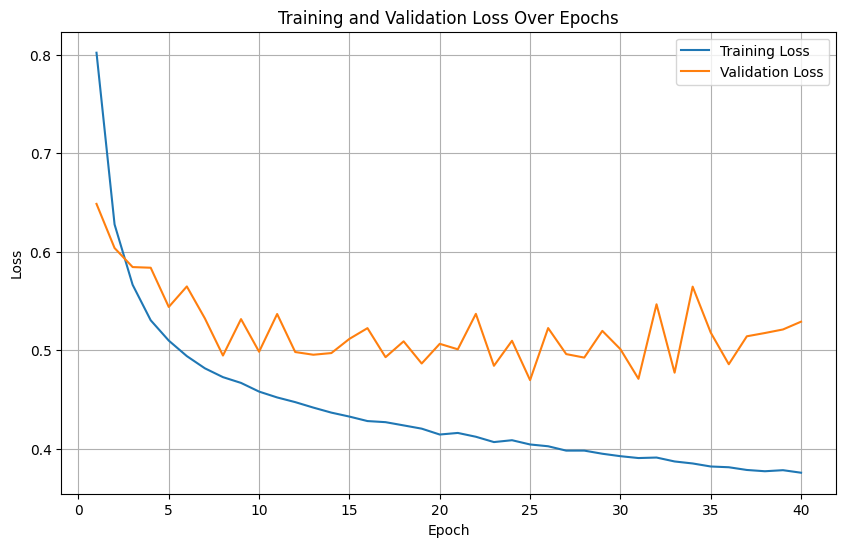

Evaluating on Validation Set...
Validation F1 Score: 0.5937700247695732


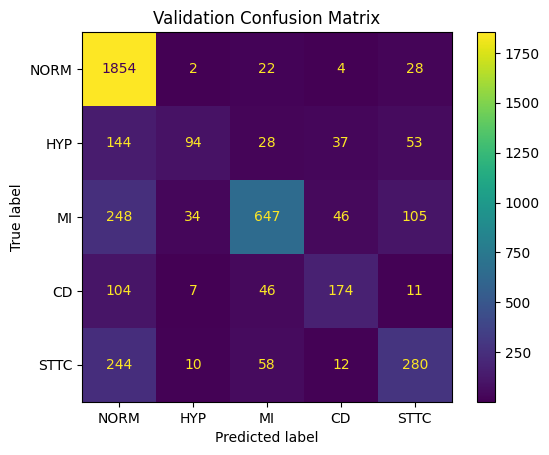

Evaluating on Training Set...
Training F1 Score: 0.6603715296054511


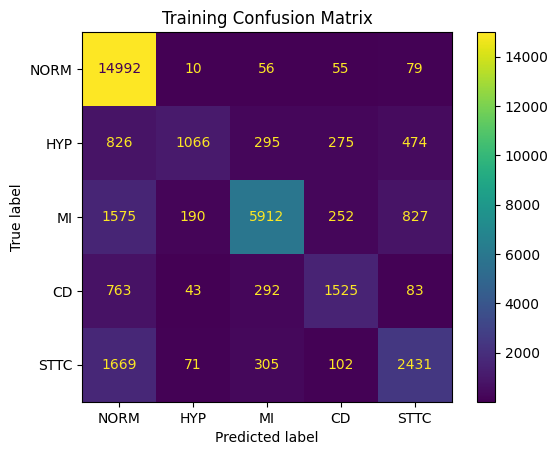


Final Comparison:
Validation F1: 0.5938
Training F1: 0.6604


In [ ]:
# Plot loss history
plot_loss_history(loss_hist_train, loss_hist_valid)

val_logits = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach()
val_pres = np.argmax(val_logits.numpy(),axis=1)
val_true = valid_dataset.tensors[1]

f1_val = metrics.f1_score(val_true, val_preds, average='macro')
print(f"Validation F1 Score: {f1_val}")

# Confusion Matrix
cm_val = metrics.confusion_matrix(val_true, val_preds, labels=range(len(labels)))
disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

train_logits = torch.Tensor.cpu(model(train_dataset.tensors[0])).detach()
train_preds = np.argmax(train_logits.numpy(), axis=1)
train_true = train_dataset.tensors[1]

f1_train = metrics.f1_score(train_true, train_preds, average='macro')
print(f"Training F1 Score: {f1_train}")

# Confusion Matrix
cm_train = metrics.confusion_matrix(train_true, train_preds, labels=range(len(labels)))
disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

print(f"\nFinal Comparison:\nValidation F1: {f1_val:.4f}\nTraining F1: {f1_train:.4f}")

Evaluating on Validation Set...
Validation F1 Score: 0.5441474250935586


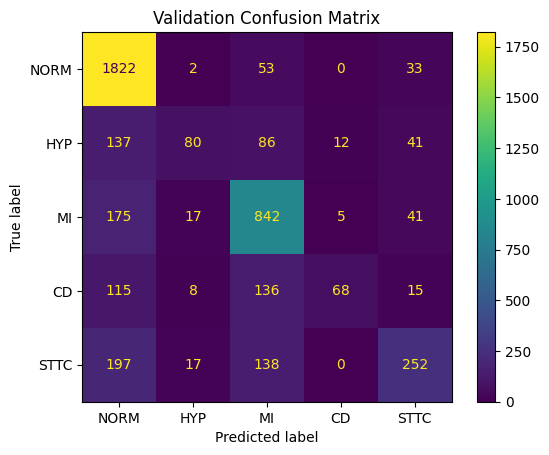

Evaluating on Training Set...


KeyboardInterrupt: 

In [ ]:
loaded_model = nn.DataParallel(TransformerECG(num_leads, embed_dim, patch_size, num_heads, depth, mlp_dim, dropout, device, seq_len)).to(device)
loaded_model.load_state_dict(torch.load('model.pth'))

val_logits = torch.Tensor.cpu(loaded_model(valid_dataset.tensors[0])).detach()
val_pres = np.argmax(val_logits.numpy(),axis=1)
val_true = valid_dataset.tensors[1]

f1_val = metrics.f1_score(val_true, val_preds, average='macro')
print(f"Validation F1 Score: {f1_val}")

# Confusion Matrix
cm_val = metrics.confusion_matrix(val_true, val_preds, labels=range(len(labels)))
disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

train_logits = torch.Tensor.cpu(loaded_model(train_dataset.tensors[0])).detach()
train_preds = np.argmax(train_logits.numpy(), axis=1)
train_true = train_dataset.tensors[1]

f1_train = metrics.f1_score(train_true, train_preds, average='macro')
print(f"Training F1 Score: {f1_train}")

# Confusion Matrix
cm_train = metrics.confusion_matrix(train_true, train_preds, labels=range(len(labels)))
disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot()
plt.title("Training Confusion Matrix")
plt.show()

print(f"\nFinal Comparison:\nValidation F1: {f1_val:.4f}\nTraining F1: {f1_train:.4f}")

Evaluating on Test Set...
Test F1 Score: 0.5358064296593225


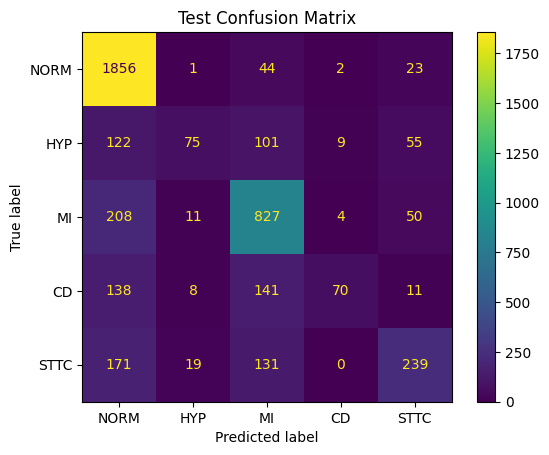

# Grid Search (defunct)

In [ ]:
import itertools
from sklearn import metrics

parameter_grid = {
    'batch_size': [32, 64, 128],
    'kernel_size': [5, 9, 13],
    'pool_size': [2, 3],
    'padding': [2, 4, 6],
    'drop_p': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
}

def grid_search(estimator, parameter_grid):

  best_val_loss = float('inf')
  best_params = {}

  best_losses = [] #0 is train 1 is valid

  best_f1 = 0

  keys = parameter_grid.keys()



  if torch.cuda.is_available():
      print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
  else:
      print("No GPU available. Training will run on CPU.")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for values in itertools.product(*parameter_grid.values()):
      current_params = dict(zip(keys, values))

      batch_size = current_params['batch_size']
      kernel_size = current_params['kernel_size']
      pool_size = current_params['pool_size']
      padding = current_params['padding']
      drop_p = current_params['drop_p']
      learning_rate = current_params['learning_rate']

      print(f"Testing parameters: {current_params}")

      model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate)

      print(f"Validation Loss: {current_val_loss}")

      pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()
      pred_val_values = np.argmax(pred_val,axis=1)

      f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')

      print(f"Validation f1: {f1_score_val}")

      plot_loss_history(loss_hist_train, loss_hist_valid)

      if current_val_loss < best_val_loss:
          best_val_loss = current_val_loss
          best_params = current_params
          best_f1 = f1_score_val
          best_losses = [loss_hist_train, loss_hist_valid]

  print(f"\nBest validation loss: {best_val_loss}")
  print(f"Best parameters: {best_params}")

  return best_params

